In [1]:
!pip install transformers

In [1]:
import os
import logging
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from random import randint, shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score
)

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import AutoModel, AutoTokenizer

In [2]:
from google.colab import drive

drive.mount('/content/drive')

%cd /content/drive/MyDrive/Text Mining Group Project/Model

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1MRcmuqFK4K9-wbwnSfbOWkpqA7tjI6vv/Text Mining Group Project/Model


In [3]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sns.set_theme()

In [5]:
class SocialMediaDS(Dataset):
    def __init__(self, data_path,
                 sheet_name,
                 model_ckpt,
                 max_token_length=50):
        super().__init__()
        self.max_token_length = max_token_length

        # label encodings
        self.emotion_labels = [
            'ANGER',
            'DISGUST',
            'FEAR',
            'JOY',
            'NEUTRAL',
            'SADNESS',
            'SURPRISE'
        ]

        # load excel
        self.data = pd.read_excel(data_path, sheet_name=sheet_name)

        self.tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
        self.tokenizer.add_special_tokens({"additional_special_tokens": ["[ENTITY]"]})

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.loc[idx, :]

        entity = row['entity']
        entity = entity.strip()

        comment = row['text']
        comment = comment.replace(entity, "[ENTITY]")
        comment = comment.split()

        # long comments
        if len(comment) > self.max_token_length:
            # get index of entity in comment
            # some entity is companied with puncatuations i.e. boarders,
            for i, word in enumerate(comment):
                if "[ENTITY]" in word:
                    entity_ind = i
                    break
            start = max(entity_ind - int(self.max_token_length/2), 0)
            end = start + self.max_token_length
            comment = comment[start:end]

        comment = ' '.join(comment)
        comment = comment.replace("\\", "")

        emotion = row['emotion']
        emotion = self.emotion_labels.index(emotion)

        return f"{comment} [SEP] [ENTITY]", emotion

    def choose(self):
        return self[randint(0, len(self)-1)]

    def get_tokenizer_size(self):
        return len(self.tokenizer)

    def decode(self, input_id):
        return self.tokenizer.decode(input_id)

    def collate_fn(self, data):
        comments, emotions = zip(*data)
        comments = self.tokenizer(comments,
                                  padding=True,
                                  return_tensors='pt')
        comments = {k:v.to(device) for k, v in comments.items()}
        emotions = torch.tensor(emotions).long().to(device)
        return comments, emotions

In [6]:
class EmotionClassifier(nn.Module):
    def __init__(self, model_ckpt,
                 emotion_nlabels=1,
                 tokenizer_size=30523,
                 dropout_prob=0.35):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_ckpt)
        self.encoder.resize_token_embeddings(tokenizer_size)
        encoder_config = self.encoder.config
        self.emotion_classifier = nn.Sequential(
            nn.BatchNorm1d(encoder_config.hidden_size),
            nn.Dropout(dropout_prob),
            nn.Linear(encoder_config.hidden_size, emotion_nlabels)
        )

        self.emotion_classifier.apply(self.init_weights)

    def init_weights(self, layer):
        if type(layer) == nn.Linear:
            nn.init.xavier_uniform_(layer.weight)

    def get_summary(self):
        print(self)

    def freeze_encoder(self):
        for param in self.encoder.parameters():
            param.requires_grad = False

    def unfreeze_encoder(self):
        for param in self.encoder.parameters():
            param.requires_grad = True

    def forward(self, x):
        x = self.encoder(**x)
        x = x.last_hidden_state[:, 0] # [cls] emb
        emotion_outputs = self.emotion_classifier(x)
        return emotion_outputs

In [7]:
def compute_metrics(targets, preds):
    targets = targets.cpu().detach()
    preds = preds.cpu().detach()
    acc = accuracy_score(targets, preds)
    f1 = f1_score(targets, preds, average='weighted')
    return {'acc': acc, 'f1': f1, 'preds': preds, 'targets':targets}

In [8]:
def focal_loss(gamma=2):
    def compute_loss(preds, targets):
        ce_loss = F.cross_entropy(preds, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        return ((1-pt)**gamma * ce_loss).mean()
    return compute_loss

In [9]:
def train(data, model, optimizer, emo_loss_fn):
    model.train()
    comments, emotions = data
    emo_outputs = model(comments)
    emo_loss = emo_loss_fn(emo_outputs, emotions)
    loss = emo_loss
    model.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Gradient clipping
    optimizer.step()

    emo_preds = emo_outputs.argmax(-1)
    emo_metrics = compute_metrics(emotions, emo_preds)
    return loss, emo_metrics

In [10]:
@torch.no_grad()
def validate(data, model, emo_loss_fn):
    model.eval()
    comments, emotions = data
    emo_outputs = model(comments)
    emo_loss = emo_loss_fn(emo_outputs, emotions)
    loss = emo_loss

    emo_preds = emo_outputs.argmax(-1)
    emo_metrics = compute_metrics(emotions, emo_preds)
    return loss, emo_metrics

In [4]:
data_path = "./en_dataset.xlsx"
train_data_path = "./train.xlsx"
val_data_path = "./val.xlsx"
sheet_name = "Sheet1"

df = pd.read_excel(data_path)
df = df.map(lambda x: x.strip() if isinstance(x, str) else x)
df = df.drop_duplicates()

neutral_df = df[df['emotion'] == 'NEUTRAL'].sample(220) # under sample neutral
df = df[df['emotion'] != 'NEUTRAL']
df = pd.concat([df, neutral_df], ignore_index = True)
print(len(df))

1414


In [5]:
df.emotion.value_counts()

,count
emotion,
NEUTRAL,220
JOY,216
SURPRISE,212
ANGER,203
SADNESS,200
FEAR,196
DISGUST,167


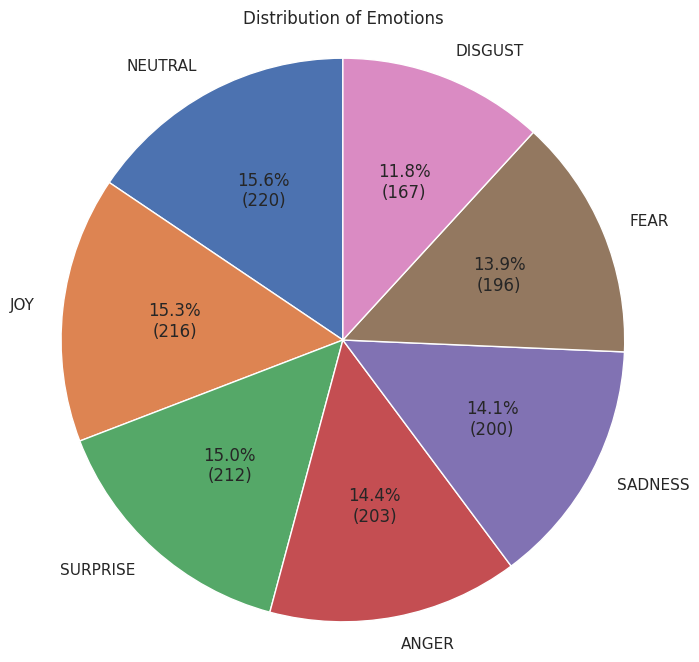

In [7]:
import matplotlib.pyplot as plt

# Data from your counts
emotions = ['NEUTRAL', 'JOY', 'SURPRISE', 'ANGER', 'SADNESS', 'FEAR', 'DISGUST']
counts = [220, 216, 212, 203, 200, 196, 167]

# Function to display percentage and count
def autopct_format(pct, allvals):
    absolute = int(round(pct/100.*sum(allvals)))
    return f"{pct:.1f}%\n({absolute})"

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=emotions, autopct=lambda pct: autopct_format(pct, counts), startangle=90)

# Equal aspect ratio ensures the pie chart is a circle
plt.axis('equal')

# Add a title
plt.title('Distribution of Emotions')

# Display the chart
plt.show()

In [13]:
train_df, val_df = train_test_split(df, stratify=df.loc[:, 'emotion'], test_size=0.1, random_state=123)
train_df.to_excel(train_data_path, index=False)
val_df.to_excel(val_data_path, index=False)
print(f'Size of training data: {len(train_df)}')
print(f'Size of validation data: {len(val_df)}')

Size of training data: 1272
Size of validation data: 142


In [14]:
model_ckpt = "bert-base-uncased"
batch_size = 16

train_ds = SocialMediaDS(train_data_path, sheet_name, model_ckpt)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=train_ds.collate_fn)
val_ds = SocialMediaDS(val_data_path, sheet_name, model_ckpt)
val_dl = DataLoader(val_ds, batch_size=batch_size, collate_fn=val_ds.collate_fn)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [15]:
model = EmotionClassifier(model_ckpt, emotion_nlabels=7).to(device)
model.unfreeze_encoder()

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [16]:
epochs = 5
loss_fn = focal_loss(2)
#loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [17]:
mem = {
    'train_loss': [],
    'train_acc': [],
    'train_f1': [],
    'val_loss': [],
    'val_acc': [],
    'val_f1': []
}

cur_best_f1 = 0

for epoch in tqdm(range(epochs), desc='Training'):

    n_batch = len(train_dl)
    train_losses = []
    train_accs = []
    train_f1s = []

    for i, data in enumerate(train_dl):
        train_loss, train_metrics = train(data, model, optimizer, loss_fn)
        pos = epoch + ((i+1)/n_batch)
        train_losses.append(train_loss.cpu().detach())
        train_accs.append(train_metrics['acc'])
        train_f1s.append(train_metrics['f1'])

    mem['train_loss'].append(np.mean(train_losses))
    mem['train_acc'].append(np.mean(train_accs))
    mem['train_f1'].append(np.mean(train_f1s))

    n_batch = len(val_dl)
    val_losses = []
    val_accs = []
    val_f1s = []

    for i, data in enumerate(val_dl):
        val_loss, val_metrics = validate(data, model, loss_fn)
        pos = epoch + ((i+1)/n_batch)
        val_losses.append(val_loss.cpu().detach())
        val_accs.append(val_metrics['acc'])
        val_f1s.append(val_metrics['f1'])
        msg = f"epoch: {pos:.3f}\tval loss: {val_loss:.3f}\tval_acc: {val_metrics['acc']:.3f}\tval_f1: {val_metrics['f1']:.3f}"

    mem['val_loss'].append(np.mean(val_losses))
    mem['val_acc'].append(np.mean(val_accs))
    mem['val_f1'].append(np.mean(val_f1s))

    # Logging
    log = (f"Epoch {epoch+1}/{epochs}\n"
           f"Train Loss: {mem['train_loss'][-1]:.3f}\tAcc: {mem['train_acc'][-1]:.3f}\tF1: {mem['train_f1'][-1]:.3f}\n"
           f"Val Loss:   {mem['val_loss'][-1]:.3f}\tAcc:   {mem['val_acc'][-1]:.3f}\tF1:   {mem['val_f1'][-1]:.3f}\n")
    tqdm.write(log)

    scheduler.step()

    # Save best model based on val_f1
    if mem['val_f1'][-1] > cur_best_f1:
        torch.save(model.state_dict(), "./saved_models/model_weights_bert.pth")
        cur_best_f1 = mem['val_f1'][-1]
        tqdm.write(f"New best F1: {cur_best_f1:.3f} - Model saved!")

print("Training completed!")

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
Train Loss: 2.011	Acc: 0.270	F1: 0.274
Val Loss:   1.229	Acc:   0.464	F1:   0.464

New best F1: 0.464 - Model saved!
Epoch 2/5
Train Loss: 1.135	Acc: 0.515	F1: 0.524
Val Loss:   1.151	Acc:   0.564	F1:   0.536

New best F1: 0.536 - Model saved!
Epoch 3/5
Train Loss: 0.702	Acc: 0.659	F1: 0.669
Val Loss:   1.337	Acc:   0.536	F1:   0.525

Epoch 4/5
Train Loss: 0.492	Acc: 0.731	F1: 0.744
Val Loss:   1.418	Acc:   0.558	F1:   0.564

New best F1: 0.564 - Model saved!
Epoch 5/5
Train Loss: 0.374	Acc: 0.802	F1: 0.812
Val Loss:   1.261	Acc:   0.629	F1:   0.634

New best F1: 0.634 - Model saved!
Training completed!


In [18]:
emo_preds, emo_targets = [], []

with torch.no_grad():
    for i, data in tqdm(enumerate(val_dl), total=len(val_dl)):
        comments, emotions = data
        emo_outputs = model(comments)

        emo_preds.extend(emo_outputs.argmax(-1).cpu().numpy())
        emo_targets.extend(emotions.cpu().numpy())

    print(classification_report(emo_targets, emo_preds))

  0%|          | 0/9 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.65      0.75      0.70        20
           1       0.56      0.53      0.55        17
           2       0.67      0.70      0.68        20
           3       0.67      0.82      0.73        22
           4       0.53      0.41      0.46        22
           5       0.50      0.45      0.47        20
           6       0.75      0.71      0.73        21

    accuracy                           0.63       142
   macro avg       0.62      0.62      0.62       142
weighted avg       0.62      0.63      0.62       142



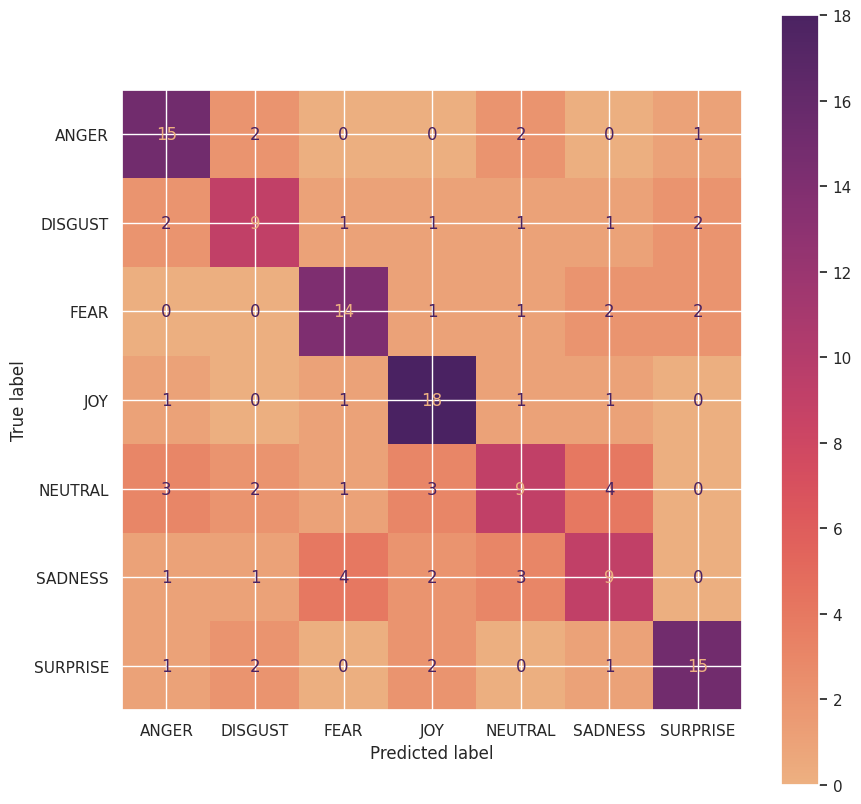

In [19]:
plt.rcParams['figure.figsize'] = [10, 10]
ConfusionMatrixDisplay.from_predictions(emo_targets, emo_preds,
                                        cmap='flare',
                                        display_labels=[
            'ANGER',
            'DISGUST',
            'FEAR',
            'JOY',
            'NEUTRAL',
            'SADNESS',
            'SURPRISE'
        ])
plt.show()

In [20]:
def get_model(model_weight_path, device):
    model_ckpt = 'bert-base-uncased'

    model = EmotionClassifier(model_ckpt, emotion_nlabels=7).to(device)
    model_weight = torch.load(model_weight_path, map_location=device, weights_only=True)
    model.load_state_dict(model_weight)
    return model

In [21]:
model_weight_path = './saved_models/model_weights_bert.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

@torch.no_grad()
def init_prediction(model):
    model = get_model(model_weight_path, device)
    model.eval()
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
    tokenizer.add_tokens(['[ENTITY]'])
    model.encoder.resize_token_embeddings(len(tokenizer))
    emotion_labels = [
        'ANGER',
        'DISGUST',
        'FEAR',
        'JOY',
        'NEUTRAL',
        'SADNESS',
        'SURPRISE'
    ]

    def predict(text, entity):
        text = text + ' [SEP] ' + entity
        text = tokenizer(text, return_tensors='pt')
        text = {k:v.to(device) for k, v in text.items()}
        emo_output = model(text)
        emo_pred = emo_output.argmax(-1).cpu().detach()
        emo_label = emotion_labels[emo_pred]

        return emo_label

    return predict

In [22]:
predictor = init_prediction(model)

In [23]:
text = "pls lah [ENTITY] is acting in our best interest lorh! meanwhile WP still saying things like they against repeal cos of religion… lame lah!"
entity = "[ENTITY]"
predictor(text, entity)

'DISGUST'

In [24]:
text = "pls lah PAP is acting in our best interest lorh! meanwhile [ENTITY] still saying things like they against repeal cos of religion… lame lah!"
entity = "[ENTITY]"
predictor(text, entity)

'DISGUST'

In [25]:
text = "I love [ENTITY] for the burger and crazy milkshakes. Good for once in few months visit."
entity = "[ENTITY]"
predictor(text, entity)

'JOY'